In [0]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import numpy as np

In [0]:
def exclude_chr(sequence):
  res = []
  for x in sequence:
    x = int(x[3:])
    res.append(x)
  return res

In [0]:
chrs = []
for i in range(1,23):
  chrs.append("chr" + str(i))

print(chrs)

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22']


In [0]:
def cpg_islands(filename):
  cpg_islands = pd.read_csv(filename, sep = '\t', header = None).iloc[:,1:4]

  cpg_islands = cpg_islands[cpg_islands[1].isin(chrs)]
  cpg_islands[1] = exclude_chr(cpg_islands[1])
  cpg_islands = cpg_islands.sort_values([1, 2])

  cpg_islands = cpg_islands.rename(columns = {1:'chr',2:'start',3:'end'})

  return cpg_islands

In [0]:
def chr_length(filename):
  chr_len = pd.read_csv(filename, sep = '\t', header = None, names = ['chr','length'])
  chr_len = chr_len[chr_len['chr'].isin(chrs)]
  chr_len['chr'] = exclude_chr(chr_len['chr'])

  return chr_len

In [0]:
islands = []
shores = []
shelves = []
seas = []
border = 2000

In [0]:
def island_bed(chrom, start, prev_chr, prev_end, prev_len):
  #same chromosome
    if prev_chr == chrom:
        if start - prev_end > (4*border):
            shores.append((chrom, prev_end, prev_end + border))
            shelves.append((chrom, prev_end + border, prev_end + 2*border))
            seas.append((chrom, prev_end + 2*border, start - 2*border))
            shelves.append((chrom, start - 2*border, start - border))
            shores.append((chrom, start - border, start))
        elif start - prev_end > (2*border):
            shores.append((chrom, prev_end, prev_end + border))
            shelves.append((chrom, prev_end + border, start - border))
            shores.append((chrom, start - border, start))                
        else:
            shores.append((chrom, prev_end, start))

    #changing chromosome
    elif prev_chr != chrom:

        if prev_len - prev_end > (2*border):
            shores.append((prev_chr, prev_end, prev_end + border))
            shelves.append((prev_chr, prev_end + border, prev_end + 2*border))
            seas.append((prev_chr, prev_end + 2*border, prev_len))
        elif prev_len - prev_end > (border):
            shores.append((prev_chr, prev_end, prev_end + border))
            shelves.append((prev_chr, prev_end + border, prev_len))
        elif prev_len - prev_end <= (border):
            shores.append((prev_chr, prev_end, prev_len))
            
        if start > (2*border):
            seas.append((chrom, 0, start - 2*border))
            shelves.append((chrom, start - 2*border, start - border))
            shores.append((chrom, start - border, start))
        elif start > (border):
            shelves.append((chrom, 0, start - border))
            shores.append((chrom, start - border, start))   
        elif start <= (border):
            shores.append((chrom, 0, start))

In [0]:
def create_bed(data):
    prev_start = data.iloc[0]['start']
    prev_end = data.iloc[0]['end']
    prev_chr = data.iloc[0]['chr']
    prev_len = data.iloc[0]['length']
    
    
    
    #first island
    islands.append((prev_chr, prev_start, prev_end))
    if prev_start > (2*border):
        seas.append((prev_chr, 0, prev_start - 2*border))
        shelves.append((prev_chr, prev_start - 2*border, prev_start - border))
        shores.append((prev_chr, prev_start - border, prev_start))
    elif prev_start > (border):
        shelves.append((prev_chr, 0, prev_start - border))
        shores.append((prev_chr, prev_start - border, prev_start))  
    elif prev_start < (border):
        shores.append((prev_chr, 0, prev_start))
    
    
    for i in range(1, data.shape[0]):
        start = data.iloc[i]['start']
        end = data.iloc[i]['end']
        chrom = data.iloc[i]['chr']        
        chrom_len = data.iloc[i]['length']
        
        island_bed(chrom, start, prev_chr, prev_end, prev_len)                
                
        prev_start = start
        prev_end = end
        prev_chr = chrom
        prev_len = chrom_len
        
        islands.append((chrom, start, end))
    
    #last island
    if prev_len - prev_end > (2*border):
        shores.append((prev_chr, prev_end, prev_end + border))
        shelves.append((prev_chr, prev_end + border, prev_end + 2*border))
        seas.append((prev_chr, prev_end + 2*border, prev_len))
    elif prev_len - prev_end > (border):
        shores.append((prev_chr, prev_end, prev_end + border))
        shelves.append((prev_chr, prev_end + border, prev_len))
    elif prev_len - prev_end <= (border):
        shores.append((prev_chr, prev_end, prev_len))

In [0]:
def save_bed_format(filename, data):
    with open(filename+'.bed', 'w') as f:
        for row in data:
            f.write("%s\t%s\t%s\n" % row)

In [0]:
def set_methylations(filename):
  dna_methylations = pd.read_csv(filename, sep = '\t', header = None).iloc[:,0:4]
  dna_methylations = dna_methylations[dna_methylations[0].isin(chrs)]
  dna_methylations[0] = exclude_chr(dna_methylations[0])
  dna_methylations = dna_methylations.sort_values([0, 1])


  dna_methylations[3] = dna_methylations[1] + round((dna_methylations[2]-dna_methylations[1])/2)
  dna_methylations[3] = dna_methylations[3].astype(int)

  dna_methylations  = dna_methylations.rename(columns = {0:'chr',1:'start',2:'end', 3:'methylation'})
  return dna_methylations

In [0]:
'''count_regions = {
  'Islands':0,
  'Shores':0, 
  'Seas': 0,
  'Shelves':0
}'''
count_islands = 0
count_shores = 0
count_seas = 0
count_shelves = 0

In [0]:
def count(dna_methylations):
  global count_islands, count_seas, count_shelves, count_shores
  for i in range(0, dna_methylations.shape[0]):
    try:
      cur_met = dna_methylations['methylation'][i]
    except Exception as e:
      #print(e)
      continue
    #print(cur_met + 'cur_met')
    #count_islands
    j = 0
    while j < len(islands) and cur_met < islands[j][2]:
      if(cur_met > islands[j][1]):
        count_islands += 1
        print(i)
        break
      else:
        j += 1

    #count_shores
    j = 0
    while j < len(shores) and cur_met < shores[j][2]:
      if(cur_met > shores[j][1]):
        count_shores += 1
        break
      else:
        j += 1

    #count_shelves
    j = 0
    while j < len(shelves) and cur_met < shelves[j][2]:
      if(cur_met > shelves[j][1]):
        count_shelves += 1
        break
      else:
        j += 1
    
    #count_seas
    j = 0
    while j < len(seas) and cur_met < seas[j][2]:
      if(cur_met > seas[j][1]):
        count_seas += 1
        break
      else:
        j += 1

In [0]:
def main():
  #First task
  cpgislands = cpg_islands('cpgIslandExt.txt')
  length = chr_length('hg19.chrom.sizes')
  data = cpgislands.merge(length)
  #print(data)

  create_bed(data)

  save_bed_format('cpg_islands', islands)
  save_bed_format('shelves', shelves)
  save_bed_format('shores', shores)
  save_bed_format('seas', seas)

  #Second task
  dna_methylations = set_methylations("HAIB.A549.EtOH.Rep.3.bed")

  #Third task
  count(dna_methylations)
  print()
        
main()

8075
79826
126281
211084
225316
316148
341649
372828
438756



<BarContainer object of 4 artists>

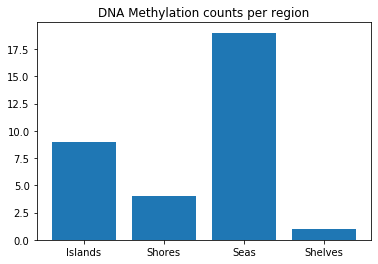

In [0]:
fig, ax = plt.subplots()
plt.title('DNA Methylation counts per region')
plt.bar(['Islands', 'Shores', 'Seas', 'Shelves'],(count_islands, count_shores, count_seas, count_shelves))
